## 問題86

In [1]:
# sklearn1.2からload_bostonは削除されたのでバージョンを下げる
!pip install scikit-learn==1.1.0
from sklearn.datasets import load_boston
import pandas as pd

In [2]:
!pip install pystan

In [3]:
# colabで非同期処理を実行するために必要
import nest_asyncio
nest_asyncio.apply()

import stan
import numpy as np
import matplotlib.pyplot as plt

In [4]:
boston = load_boston()
boston_df = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
stan_code = '''
data {
  int N;
  int M;
  vector[N] y;
  matrix[N, M] x;
  real beta;
}

parameters {
  vector[M] b;
  real<lower=0> sigma;
}

model {
  for (n in 1:N)
    target += beta * normal_lpdf(y[n] | x[n] * b, sigma);
}

generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(y[n] | x[n] * b, sigma);
}
'''

In [6]:
def T_n(log_likelihood):
    return -np.mean(np.log(np.mean(np.exp(log_likelihood), axis=1)))

def V_n(log_likelihood):
    return np.mean(np.mean(log_likelihood**2, axis=1) - np.mean(log_likelihood, axis=1)**2)

def CV(log_likelihood, beta):
    t1 = np.log(np.mean(np.exp((1 - beta) * log_likelihood), axis=1))
    t2 = np.log(np.mean(np.exp(-beta * log_likelihood), axis=1))
    return -np.mean(t1 - t2)

def WAIC(log_likelihood, beta):
    return T_n(log_likelihood) + beta * V_n(log_likelihood)


In [9]:
index = [0, 2, 4, 5, 6, 7, 9, 10, 11, 12]
df = boston_df.iloc[:, index]
N = df.shape[0]
K = len(index)
Y = np.array(boston.target)
X = df.to_numpy()

beta_seq = np.arange(0.1, 1.7, 0.1)
waic_values = []
cv_values = []

for beta in beta_seq:
    data_list = {'N': N, 'M': K, 'y': Y, 'x': X, 'beta': beta}
    stan_model = stan.build(stan_code, data=data_list, random_seed=1)
    fit = stan_model.sample(num_samples=100, num_chains=1)
    log_lik = fit['log_lik']
    waic_values.append(N * WAIC(log_lik, beta))
    cv_values.append(N * CV(log_lik, beta))


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000408 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.08 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=RuntimeError("connect: Connection refused [system:111 at httpstan/include/boost/asio/detail/reactive_socket_service.hpp:587 in function 'connect']")>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: connect: Connection refused [system:111 at httpstan/inclu

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000138 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.38 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000148 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.48 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1000/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000147 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.47 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000185 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.85 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000166 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.66 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000138 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.38 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000148 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.48 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000378 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.78 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000174 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.74 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000181 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.81 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000144 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.44 seconds.
  Adjust your expectations accordingly!


Building...

ERROR:asyncio:Future exception was never retrieved
future: <Future finished exception=RuntimeError("connect: Connection refused [system:111 at httpstan/include/boost/asio/detail/reactive_socket_service.hpp:587 in function 'connect']")>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: connect: Connection refused [system:111 at httpstan/include/boost/asio/detail/reactive_socket_service.hpp:587 in function 'connect']
"""

The above exception was the direct cause of the following exception:

RuntimeError: connect: Connection refused [system:111 at httpstan/include/boost/asio/detail/reactive_socket_service.hpp:587 in functio


Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000143 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.43 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000209 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.09 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/1100)
Sampling:   9% (100/1100)
Sampling:  18% (200/1100)
Sampling:  27% (300/1100)
Sampling:  36% (400/1100)
Sampling:  45% (500/1100)
Sampling:  55% (600/1100)
Sampling:  64% (700/1100)
Sampling:  73% (800/1100)
Sampling:  82% (900/1100)
Sampling:  91% (1001/1100)
Sampling: 100% (1100/1100)
Sampling: 100% (1100/1100), done.
Messages received during sampling:
  Gradient evaluation took 0.000183 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.83 seconds.
  Adjust your expectations accordingly!


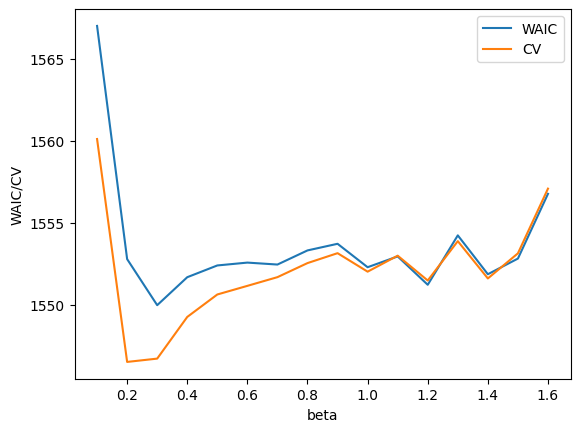

In [10]:
plt.plot(beta_seq, waic_values, label='WAIC')
plt.plot(beta_seq, cv_values, label='CV')
plt.xlabel('beta')
plt.ylabel('WAIC/CV')
plt.legend()